In [3]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(2021)

# 1. Data

1.1 Sample Data

In [8]:
from sklearn.datasets import make_moons

data, label = make_moons(n_samples=300, shuffle=True, noise=0.5, random_state=2021)

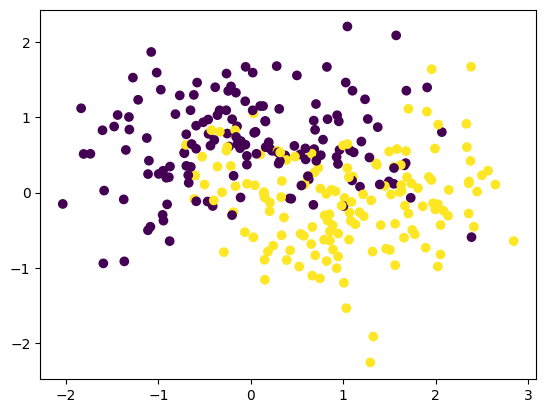

In [9]:
plt.scatter(data[:, 0], data[:, 1], c=label)

1.2 Resample Data

In [10]:
# 150:150으로 잘 분류된 데이터를 한쪽 데이터 줄이기
from imblearn.datasets import make_imbalance
from collections import Counter


def ratio_func(y, multiplier, minority_class):
    target_stats = Counter(y)
    return {minority_class: int(multiplier * target_stats[minority_class])}

data, label = make_imbalance(
    data,
    label,
    sampling_strategy=ratio_func,
    **{"multiplier": 0.1, "minority_class": 1,}
)

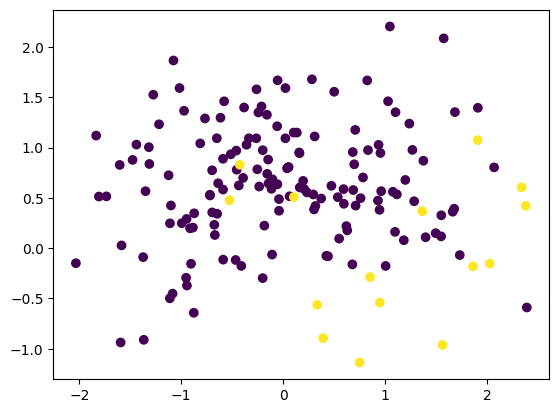

In [11]:
plt.scatter(data[:, 0], data[:, 1], c=label)

In [13]:
pd.Series(label).value_counts()

0    150
1     15
dtype: int64

1.3 Split Data

In [17]:
from sklearn.model_selection import train_test_split
# stratify를 사용해서 같은 비율로 데이터 나누게 함
train_data, test_data, train_label, test_label = train_test_split(
    data, label, train_size = 0.7, random_state=2021, stratify = label
)

In [18]:
train_label.mean()

0.08695652173913043

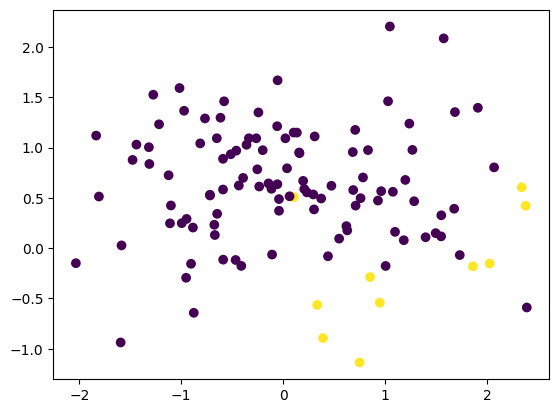

In [20]:
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_label)

In [22]:
test_label.mean()

0.1

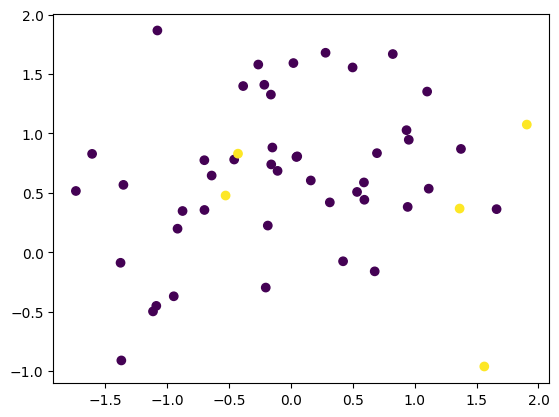

In [24]:
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_label)

1.4 시각화 데이터

In [25]:
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# 2. Model

In [26]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

2.1 학습&예측

In [27]:
tree.fit(train_data, train_label)

DecisionTreeClassifier()

In [28]:
tree_train_pred = tree.predict(train_data)
tree_test_pred = tree.predict(test_data)

2.3 평가

정확도

In [29]:
from sklearn.metrics import accuracy_score

tree_train_acc = accuracy_score(train_label, tree_train_pred)
tree_test_acc = accuracy_score(test_label, tree_test_pred)

In [30]:
print(f"Tree train accuray is {tree_train_acc:.4f}")
print(f"Tree test accuray is {tree_test_acc:.4f}")   

Tree train accuray is 1.0000
Tree test accuray is 0.8800


In [ ]:
# accuracy의 경우 majority에 있는 데이터만 잘 맞춰도 높게 나옴 > F1 통해서 이상 데이터도 잘 맞췄는지 확인

F1 Score

In [31]:
from sklearn.metrics import f1_score

tree_train_f1 = f1_score(train_label, tree_train_pred)
tree_test_f1 = f1_score(test_label, tree_test_pred)

In [32]:
print(f"Tree train F1-Score is {tree_train_f1:.4f}")
print(f"Tree test F1-Score is {tree_test_f1:.4f}")   

Tree train F1-Score is 1.0000
Tree test F1-Score is 0.2500


2.4 시각화

In [33]:
tree_Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
tree_Z = tree_Z.reshape(xx.shape)

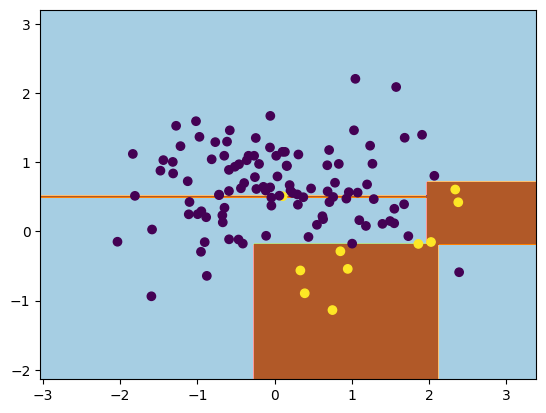

In [34]:
cs = plt.contourf(xx, yy, tree_Z, cmap=plt.cm.Paired)
plt.scatter(train_data[:,0], train_data[:,1], c=train_label)

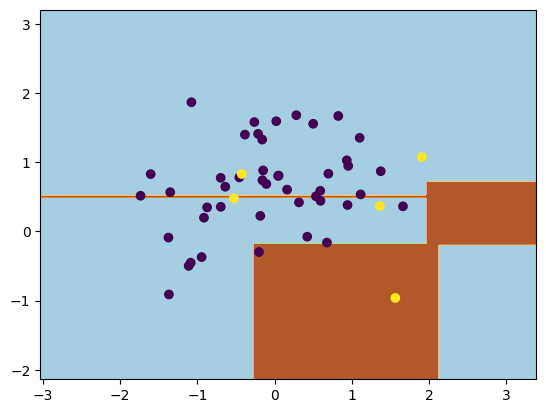

In [35]:
cs = plt.contourf(xx, yy, tree_Z, cmap=plt.cm.Paired)
plt.scatter(test_data[:,0], test_data[:,1], c=test_label)

# 3. Under Sampling

3.1 Under Sampling data

In [37]:
from imblearn.under_sampling import RandomUnderSampler, NearMiss

under_dict = {}

rus = RandomUnderSampler(random_state=2021)
rus_data, rus_label = rus.fit_resample(train_data, train_label)
under_dict["rus"] = {"data": rus_data, "label": rus_label}

In [38]:
for i in range(1, 4):
    near_miss = NearMiss(version=i)
    near_data, near_label = near_miss.fit_resample(train_data, train_label)
    under_dict[f"near_{i}"] = {
        "data": near_data, "label": near_label
    }

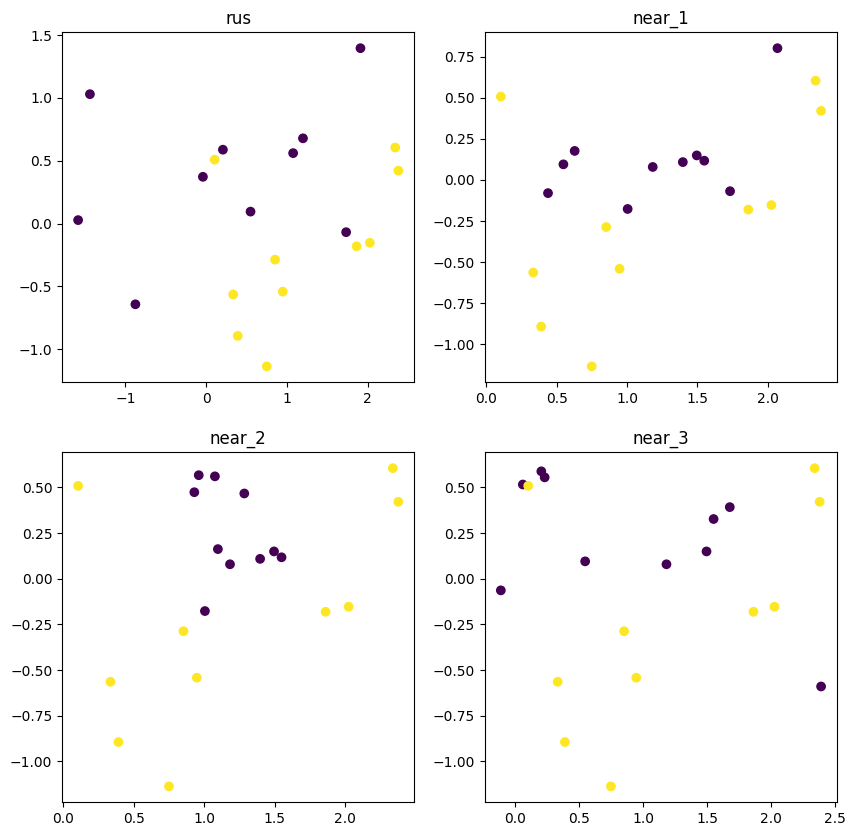

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, sample) in enumerate(under_dict.items()):
    ax = axes[idx//2, idx%2]
    d, l = sample["data"], sample["label"]
    ax.scatter(d[:, 0], d[:, 1], c=l)
    ax.set_title(name)

3.2 학습

In [40]:
under_model = {}
for name, sample in under_dict.items():
    under_tree = DecisionTreeClassifier()
    under_tree.fit(sample["data"], sample["label"])
    under_model[name] = under_tree

In [41]:
under_model

{'rus': DecisionTreeClassifier(),
 'near_1': DecisionTreeClassifier(),
 'near_2': DecisionTreeClassifier(),
 'near_3': DecisionTreeClassifier()}

3.3 예측

In [42]:
under_pred = {}
for name, under_tree in under_model.items():
    under_test_pred = under_tree.predict(test_data)
    under_pred[name] = under_test_pred

In [43]:
under_pred

{'rus': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]),
 'near_1': array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1]),
 'near_2': array([0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1]),
 'near_3': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1])}

3.4 평가

정확도

In [44]:
for name, pred in under_pred.items():
    acc = accuracy_score(test_label, pred)
    print(f"{name} Sampling test accuray is {acc:.4f}")

rus Sampling test accuray is 0.8400
near_1 Sampling test accuray is 0.1800
near_2 Sampling test accuray is 0.3400
near_3 Sampling test accuray is 0.8000


F1 Score

In [45]:
for name, pred in under_pred.items():
    f1 = f1_score(test_label, pred)
    print(f"{name} Sampling test F1-Score is {f1:.4f}")

rus Sampling test F1-Score is 0.2000
near_1 Sampling test F1-Score is 0.1633
near_2 Sampling test F1-Score is 0.1951
near_3 Sampling test F1-Score is 0.1667


3.5 시각화

Train Data

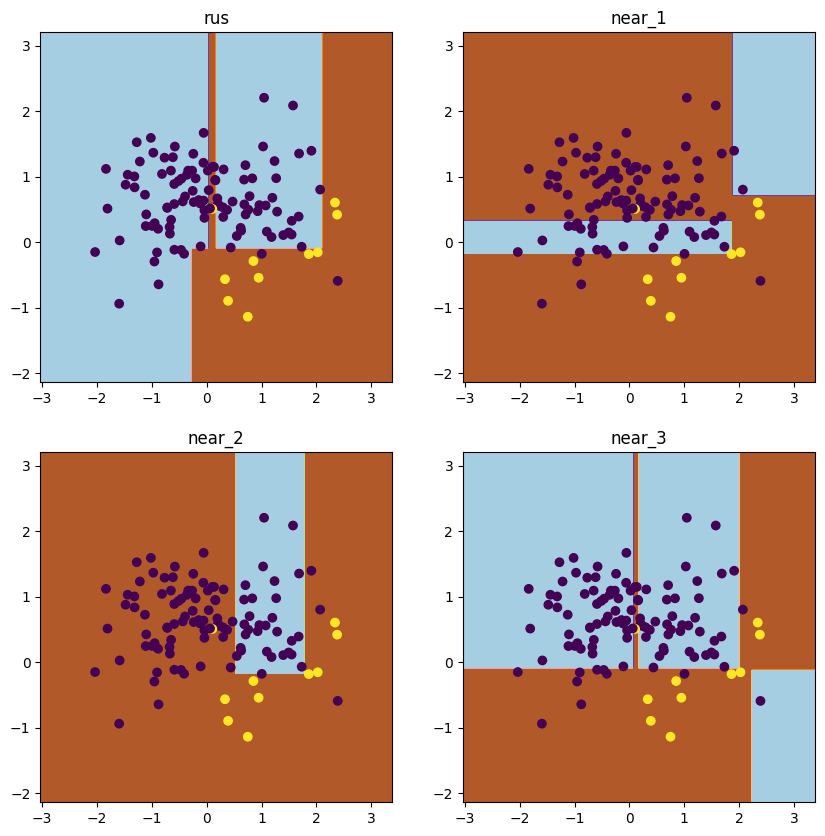

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, under_tree) in enumerate(under_model.items()):
    ax = axes[idx//2, idx%2]
    under_Z = under_tree.predict(np.c_[xx.ravel(), yy.ravel()])
    under_Z = under_Z.reshape(xx.shape)
    ax.contourf(xx, yy, under_Z, cmap=plt.cm.Paired)
    ax.scatter(train_data[:,0], train_data[:,1], c=train_label)
    ax.set_title(name)

Test Data

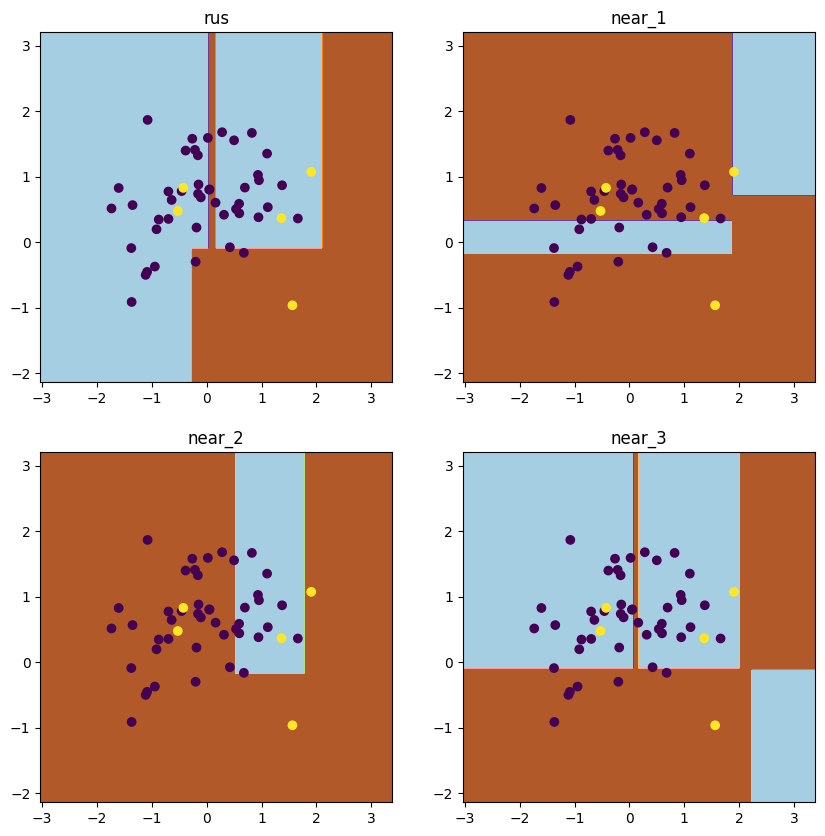

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, (name, under_tree) in enumerate(under_model.items()):
    ax = axes[idx//2, idx%2]
    under_Z = under_tree.predict(np.c_[xx.ravel(), yy.ravel()])
    under_Z = under_Z.reshape(xx.shape)
    ax.contourf(xx, yy, under_Z, cmap=plt.cm.Paired)
    ax.scatter(test_data[:,0], test_data[:,1], c=test_label)
    ax.set_title(name)

# 4. Over Sampling

In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=2021)

In [49]:
smote_data, smote_label = smote.fit_resample(train_data, train_label)

In [50]:
smote_data[:10]

array([[ 1.0963906 ,  0.16215513],
       [ 0.43879078, -0.0803489 ],
       [ 0.20618849,  0.58791678],
       [-0.59047253,  0.58307246],
       [ 1.73131008, -0.06861231],
       [ 0.10237896,  1.1495802 ],
       [ 0.23230422,  0.55483897],
       [-1.1107737 ,  0.24678492],
       [ 0.94696029, -0.54173336],
       [-0.87710056, -0.64256821]])

In [51]:
smote_label[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

Text(0.5, 1.0, 'smote data')

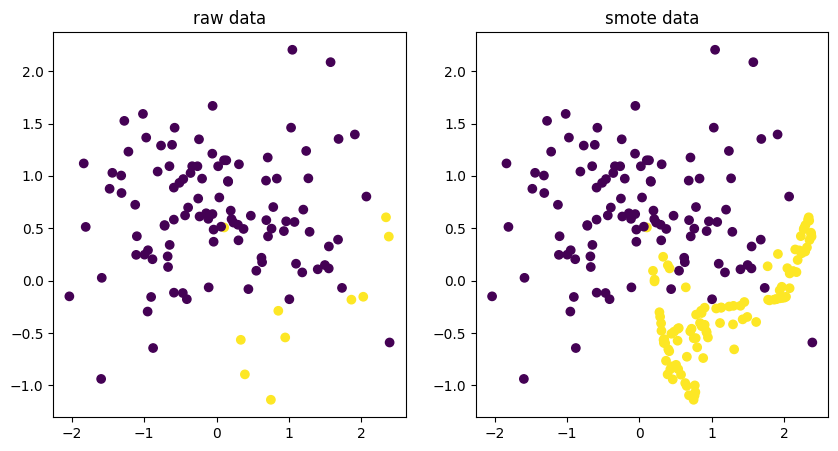

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].scatter(train_data[:, 0], train_data[:, 1], c=train_label)
axes[0].set_title("raw data")

axes[1].scatter(smote_data[:,0], smote_data[:,1], c=smote_label)
axes[1].set_title("smote data")

4.2 학습

In [53]:
smote_tree = DecisionTreeClassifier()
smote_tree.fit(smote_data, smote_label)

DecisionTreeClassifier()

4.3 예측

In [54]:
smote_test_pred = smote_tree.predict(test_data)

4.4 평가

정확도

In [55]:
smote_acc = accuracy_score(test_label, smote_test_pred)
print(f"SMOTE test accuray is {smote_acc:.4f}")

SMOTE test accuray is 0.9000


F1 Score

In [56]:
smote_f1 = f1_score(test_label, smote_test_pred)
print(f"SMOTE test F1-Score is {smote_f1:.4f}")

SMOTE test F1-Score is 0.2857


4.5 시각화

In [57]:
smote_Z = smote_tree.predict(np.c_[xx.ravel(), yy.ravel()])
smote_Z = smote_Z.reshape(xx.shape)

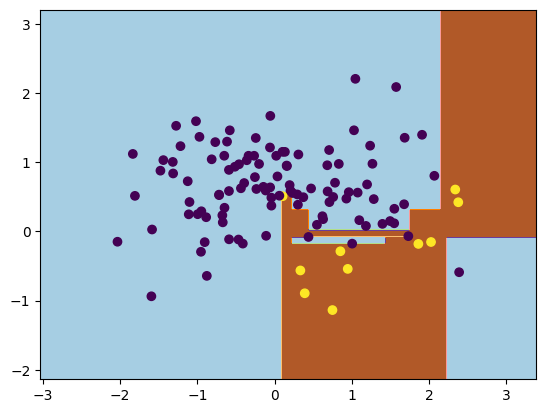

In [58]:
cs = plt.contourf(xx, yy, smote_Z, cmap=plt.cm.Paired)
plt.scatter(train_data[:,0], train_data[:,1], c=train_label)

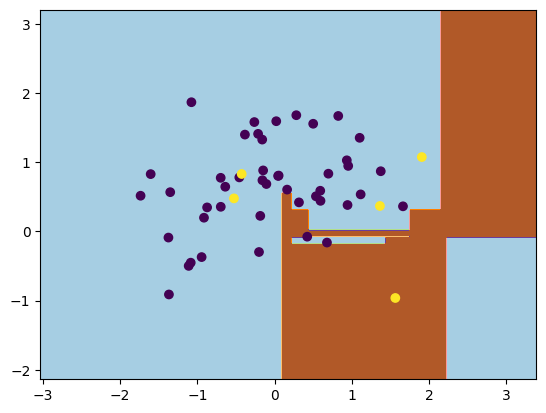

In [59]:
cs = plt.contourf(xx, yy, smote_Z, cmap=plt.cm.Paired)
plt.scatter(test_data[:,0], test_data[:,1], c=test_label)

# 5. 마무리

5.1 정확도

In [60]:
print(f"Tree test accuray is {tree_test_acc:.4f}")   
for name, pred in under_pred.items():
    acc = accuracy_score(test_label, pred)
    print(f"{name} Sampling test accuray is {acc:.4f}")
print(f"SMOTE test accuray is {smote_acc:.4f}")

Tree test accuray is 0.8800
rus Sampling test accuray is 0.8400
near_1 Sampling test accuray is 0.1800
near_2 Sampling test accuray is 0.3400
near_3 Sampling test accuray is 0.8000
SMOTE test accuray is 0.9000


5.2 F1 Score

In [61]:
print(f"Tree test F1-Score is {tree_test_f1:.4f}")   
for name, pred in under_pred.items():
    f1 = f1_score(test_label, pred)
    print(f"{name} Sampling test F1-Score is {f1:.4f}")
print(f"SMOTE test F1-Score is {smote_f1:.4f}")

Tree test F1-Score is 0.2500
rus Sampling test F1-Score is 0.2000
near_1 Sampling test F1-Score is 0.1633
near_2 Sampling test F1-Score is 0.1951
near_3 Sampling test F1-Score is 0.1667
SMOTE test F1-Score is 0.2857
